# Basic Results + MAE

This notebook allows you to see basic results from the model, including the population pattern of usage ($\mu$) and correlation in routines across days of the week ($\Omega_\eta$). 

It also computes the in-sample fit and forecasts, and plots these both in the aggregate and over time. 

This notebook is useful for doing a quick evaluation of the results.

In [1]:
# Base imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import arviz as az

# Other imports
from numpy import pi as pi

# New plotting imports
import seaborn as sns

## Load the trace

Adjust the following path to load whatever posterior you're analyzing:

In [20]:
run_name = "routines_model_2024-07-19_16-20-30-747185"
trace = az.from_netcdf(os.path.join("../model/outputs", run_name, "posterior.nc"))

## Basic results: Population patterns

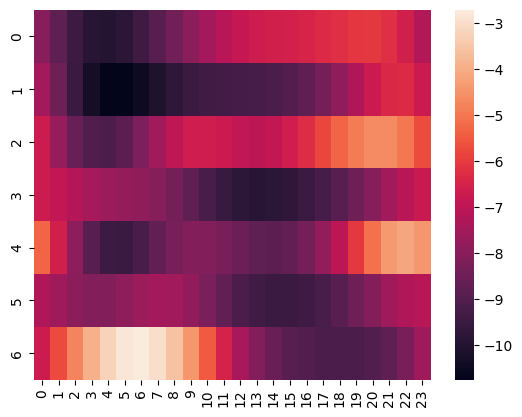

In [24]:
post_mean_mu = trace.posterior['mu'].mean(axis = (0,1)).to_numpy()
sns.heatmap(post_mean_mu.reshape(7,24));

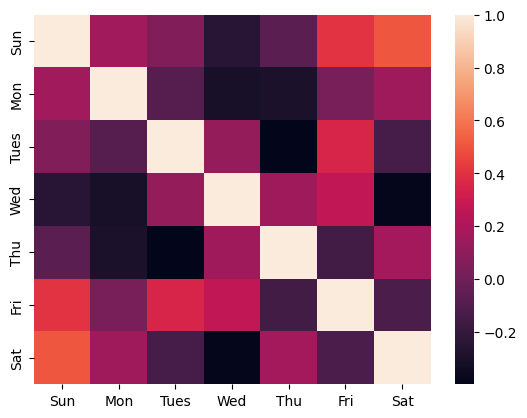

In [23]:
post_mean_daycorrs = trace.posterior['eta_omega_corr'].to_numpy().mean(axis = (0,1))
corr_plot = sns.heatmap(post_mean_daycorrs, xticklabels=['Sun','Mon','Tues',"Wed","Thu",'Fri','Sat'], yticklabels=['Sun','Mon','Tues',"Wed","Thu",'Fri','Sat'])
corr_plot;

## Stacking the samples

This just simplifies subsequent code:

In [6]:
trace.stack(sample=["chain", "draw"], inplace = True)

## Posterior predictive

In [7]:
n_cust = trace.posterior['alpha'].shape[0]

train = pd.read_csv("../../data/train.csv")
train = train[train['id'] <= n_cust]

test = pd.read_csv("../../data/test.csv")
test = test[test['id'] <= n_cust]

n_weeks_train = train['week'].nunique()
n_people, n_weeks_total, n_samples = trace.posterior['alpha'].shape
n_dayhours = 168

# Training period data:
calls_by_week = train.groupby(['id','week'])['y'].sum()
id_week_idx = np.array(list(calls_by_week.index)) - 1
true_requests = np.zeros(shape = (n_people, n_weeks_train))
true_requests[id_week_idx[:,0], id_week_idx[:,1]] = train.groupby(["id", "week"])['y'].sum()

# Just test period data:
test_calls_by_week = test.groupby(['id','week'])['y'].sum()
id_week_idx = np.array(list(test_calls_by_week.index)) - 1
test_requests = np.zeros(shape = (n_people, n_weeks_total))
test_requests[id_week_idx[:,0], id_week_idx[:,1]] = test.groupby(["id", "week"])['y'].sum()
test_requests = test_requests[:,n_weeks_train:]

# Combined:
true_reqs_all = np.hstack((true_requests, test_requests))

# Routine part, posterior median:
decomp_routine = np.array([[np.median(np.exp(trace.posterior['eta'].values[i] + trace.posterior['gamma'].values[i,w]).sum(axis = 0)) for w in range(n_weeks_total)] for i in range(n_people)])

# "Random" part, posterior median:
decomp_random = np.array([[np.median(np.exp(trace.posterior['alpha'].values[i,w] + trace.posterior['mu'].values).sum(axis = 0)) for w in range(n_weeks_total)] for i in range(n_people)])

In [26]:
true_reqs_all.shape

(50, 20)

### In-sample Fit

Text(0.5, 0, 'Expected')

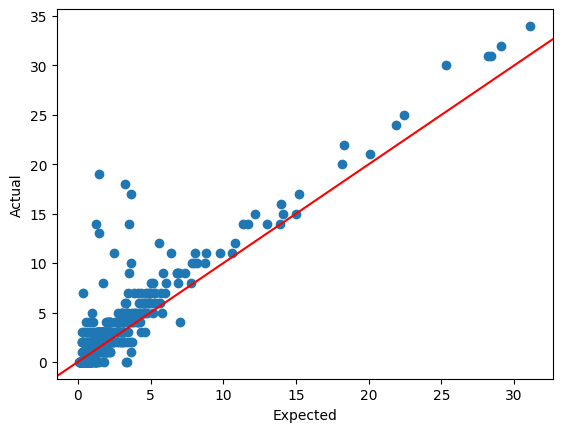

In [9]:
fig, ax = plt.subplots()
ax.scatter(decomp_routine[:,:n_weeks_train] + decomp_random[:,:n_weeks_train], true_requests)
ax.axline([1,1], slope=1, color="red")
ax.set_ylabel("Actual")
ax.set_xlabel("Expected")


### Forecasts

In [14]:
ppd_reqs = np.array([[(np.exp(trace.posterior['eta'].values[i] + trace.posterior['gamma'].values[i,w]) + \
    np.exp(trace.posterior['alpha'].values[i,w] + trace.posterior['mu'].values)).sum(axis=0) for w in range(n_weeks_total)] for i in range(n_people)])
expected_reqs = np.median(ppd_reqs, axis = 2)

E_train_reqs = expected_reqs[:,:n_weeks_train]
E_fore_reqs = expected_reqs[:,n_weeks_train:]

Plot true vs. expected, over all weeks:

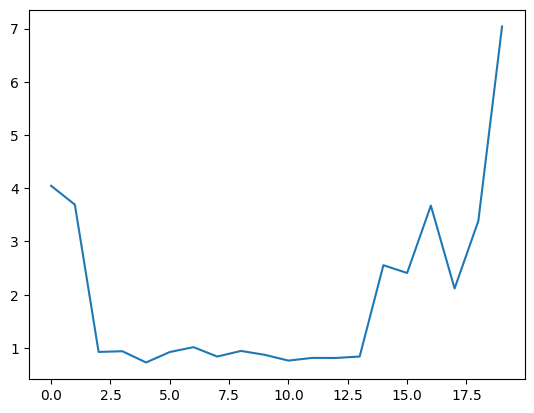

In [15]:
plt.plot(np.sqrt(np.mean((true_reqs_all - expected_reqs)**2, axis = 0)))

Holdout error:

In [16]:
abs_err = np.abs(test_requests.sum(1) - E_fore_reqs.sum(1))
abs_err.mean()

8.525796022852493

In [17]:
print(f"95% ci: {abs_err.mean() - 2*abs_err.std()/np.sqrt(len(abs_err))}, {abs_err.mean() + 2*abs_err.std()/np.sqrt(len(abs_err))}")

95% ci: 5.969232807505978, 11.082359238199007
